# Chemical gas sensor drift compensation

Для анализа взят набор данных, полученный с газовых сенсоров при анализе набора веществ с разными концентрациями.
Сам набор был получен для анализа дрейфа сенсоров, и состоит из 10 файлов, записанных последовательно в течение нескольких месяцев.

Целью анализа набора данных с моей стороны было определение как страдает предсказание анализируемого вещества, если использовать не все анализируемые параметры, а только амплитуду импульса, представленную для каждого сенсора первыми двумя параметрами ( Δ𝑅, ‖Δ𝑅‖), потому что их достаточно легко получать, а остальные - затруднително (в моих собствненых экспериментах).
Кроме того для анализа брался только первый файл из набора (для ускорения и упрощения).

Сам набор данных расположен тут: 
https://archive.ics.uci.edu/dataset/270/gas+sensor+array+drift+dataset+at+different+concentrations

Его описание в виде статьи приводится тут (но используется набор данных без указания концентрации):
"Alexander Vergara, Shankar Vembu, Tuba Ayhan, Margaret A. Ryan, Margie L. Homer, Ramón Huerta,Chemical gas sensor drift compensation using classifier ensembles, Sensors and Actuators B: Chemical, Volumes 166–167, 2012, Pages 320-329, ISSN 0925-4005,
https://doi.org/10.1016/j.snb.2012.01.074.

Также данные используются в статье 
Dong, X.; Han, S.; Wang, A.; Shang, K. Online Inertial Machine Learning for Sensor Array Long-Term Drift Compensation. Chemosensors 2021, 9, 353. https://doi.org/10.3390/chemosensors9120353 ), are placed there: https://github.com/Diaa0/Sensor-Drift-Array-Compensation.

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

from matplotlib import pyplot as plt # import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


import os
import re

path = 'Dataset/'

## Структура данных

Каждый отклик описан 8 признаками:  Δ𝑅, ‖Δ𝑅‖, 𝑒𝑚𝑎0.001𝐼, 𝑒𝑚𝑎0.01𝐼, 𝑒𝑚𝑎0.1𝐼, 𝑒𝑚𝑎0.001𝐷, 𝑒𝑚𝑎0.01𝐷, and 𝑒𝑚𝑎0.1𝐷. Регистрируется 16 сенсорами, итого каждый отклик описан 128 признаками.

Используемые аналиты: 
* 1: Ethanol; 2: Ethylene; 3: Ammonia; 4: Acetaldehyde; 5: Acetone; 6: Toluene

Строка состоит из индикатора аналита (1-6), концентрации (ppmv), и 128 признаков:
* 1;10.000000 1:15596.162100 2:1.868245 3:2.371604 ... 127:-0.902241 128:-2.654529 


## original description

The dataset is organized in files, each representing a different batch. Within the files, each line represents a measurement. The first character (1-6) codes the analyte, followed by the concentration level:



1: Ethanol; 2: Ethylene; 3: Ammonia; 4: Acetaldehyde; 5: Acetone; 6: Toluene



The data format follows the same coding style as in libsvm format x:v, where x stands for the feature number and v for the actual value of the feature. For example, in 

1;10.000000 1:15596.162100 2:1.868245 3:2.371604 4:2.803678 5:7.512213 ... 128:-2.654529 



The number 1 stands for the class number (in this case Ethanol), the gas concentration level was 10ppmv, and the remaining 128 columns list the actual feature values for each measurement recording organized as described above. 

## Импорт и начальный анализ набора данных.


Загружаю файл и упаковываю в структуру, где каждая строка это кортеж "ЛОС, концентрацию и 128 особенностей".

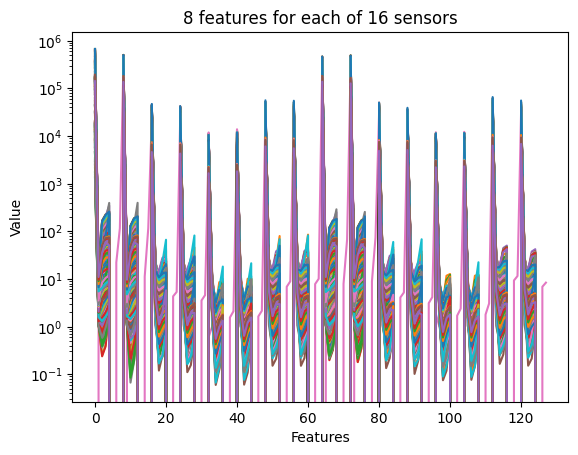

In [2]:
gas_data = []

voc = {1: 'Ethanol', 2: 'Ethylene', 3: 'Ammonia', 4: 'Acetaldehyd', 5: 'Acetone', 6: 'Toluene'}

with open(path + 'batch1.dat', 'r') as file_data:
    for i, line in enumerate(file_data.readlines()):
#        gas_type = int(line[0])
#        rest = line[1:]
        data = line.strip().split(' ') 
        gas_type, conc = data[0].strip().split(';')
        gas_type = voc[int(gas_type)]
#        print(data)
        # split in pairs by spaces and then split pairs by colons    
        x, y = zip(*[(int(i.strip().split(':')[0]), float(i.strip().split(':')[1])) for i in data[1:]])
        gas_data.append((gas_type, float(conc), y))
#        gas_data.append((gas_type, float(conc), (x, y)))


plt.figure()

for i in gas_data:
    plt.plot(i[2])
#    plt.plot(i[2][0], i[2][1])


plt.title('8 features for each of 16 sensors')
plt.xlabel("Features")
plt.ylabel("Value")
plt.yscale('log')
plt.show()

Можно построить как меняется во времени одна из особенностях (первая), или несколько - но конкретно delta_R (она первая в каждом наборе, и выбрать её можно по индексу, умножая его на 8).

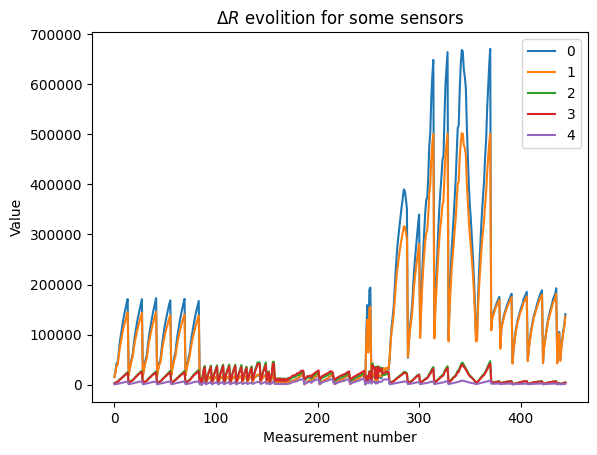

In [3]:
plt.figure()

features = 5

for i in range(features):
    y = [j[2][i*8] for j in gas_data]
    plt.plot(y, label=i)
#    plt.plot(i[2][0], i[2][1])

plt.title('$\Delta R$ evolition for some sensors')
plt.xlabel("Measurement number")
plt.ylabel("Value")

plt.legend()

plt.show()

Видно что для каждого анализируемого вещества по нескольку раз исследуются возрастающие наборы концетраций. И если бы измерялась "нулевая" концентарция - то они все шли бы и от нуля. 
Данные, очевидно, распределены равномерно ,а не нормально.

А теперь можно взять концентрацию как координату Х, раскрасив цветом тип аналита.

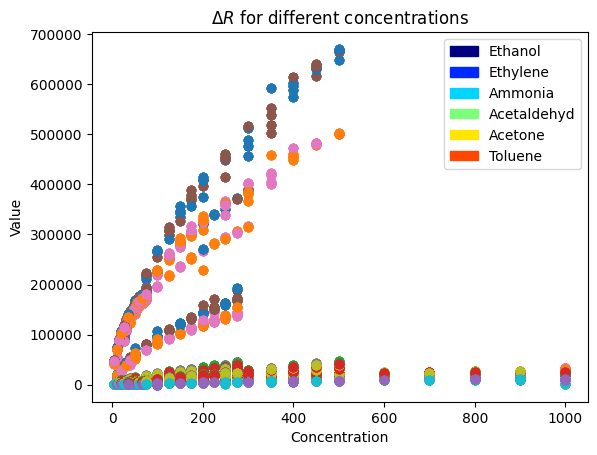

In [4]:
plt.figure()

features = 5

colors = [plt.cm.jet(float(i)/len(voc)) for i in range(len(voc))]


for n,v in voc.items():
    col = np.expand_dims(np.array(colors[n-1]), axis=0)
    for j in gas_data:
        if j[0] == v:
            for i in range(features):
                x = [j[1] for m in range(features)]
                #x = [j[1] for j in range(features)]
                y = [j[2][i*8] for m in range(features)]
                plt.scatter(x, y)#, color=col)


pathes = []
for n,v in voc.items():
    pathes.append(mpatches.Patch(color=np.expand_dims(np.array(colors[n-1]), axis=0), label=v))
plt.legend(handles=pathes)

plt.title('$\Delta R$ for different concentrations ')
plt.xlabel("Concentration")
plt.ylabel("Value")

plt.show()

# Dataframe

Теперь собираем датафрейм и проводим первичный анализ данных - строим парные графики для набора сенсоров (и увидеть которые сильнее коррелируют и какие слабее?).

In [5]:
# Предыдущий вариант импорта был хорош для рисования, хотя можно было изменить трехмерное обращение к данным на добавление индекса +2, чтобы не затрагивать первые колонки

gas_data = []

voc = {1: 'Ethanol', 2: 'Ethylene', 3: 'Ammonia', 4: 'Acetaldehyd', 5: 'Acetone', 6: 'Toluene'}

with open(path + 'batch1.dat', 'r') as file_data:
    for i, line in enumerate(file_data.readlines()):
#        gas_type = int(line[0])
#        rest = line[1:]
        data = line.strip().split(' ') 
        gas_type, conc = data[0].strip().split(';')
        gas_type = voc[int(gas_type)]
#        print(data)
        # split in pairs by spaces and then split pairs by colons    
        x, y = zip(*[(int(i.strip().split(':')[0]), float(i.strip().split(':')[1])) for i in data[1:]])
        gas_data.append([gas_type] + [conc] + list(y))
#        gas_data.append((gas_type, float(conc), (x, y)))

In [6]:
features = ('R', '‖ΔR‖', 'ema0.001l', 'ema0.01l', 'ema0.1l', 'ema0.001D', 'ema0.01D', 'ema0.1D')
sensors = [str(i) for i in range(16)]

df_columns = ['VOC', 'conc']
for i in sensors:
    for j in features:
        df_columns.append('s' + i + '_' + j)


df = pd.DataFrame(gas_data, columns=df_columns)
#print(df)
df.head()

VOC       conc        s0_R   s0_‖ΔR‖  s0_ema0.001l  s0_ema0.01l  \
0  Ethanol  10.000000  15596.1621  1.868245      2.371604     2.803678   
1  Ethanol  20.000000  26402.0704  2.532401      5.411209     6.509906   
2  Ethanol  30.000000  42103.5820  3.454189      8.198175    10.508439   
3  Ethanol  40.000000  42825.9883  3.451192     12.113940    16.266853   
4  Ethanol  50.000000  58151.1757  4.194839     11.455096    15.715298   

   s0_ema0.1l  s0_ema0.001D  s0_ema0.01D  s0_ema0.1D  ...  s14_ema0.01D  \
0    7.512213     -2.739388    -3.344671   -4.847512  ...     -1.071137   
1    7.658469     -4.722217    -5.817651   -7.518333  ...     -1.530519   
2   11.611003     -7.668313    -9.478675  -12.230939  ...     -2.384784   
3   39.910056     -7.849409    -9.689894  -11.921704  ...     -2.607199   
4   17.654915    -11.083364   -13.580692  -16.407848  ...     -3.594763   

   s14_ema0.1D      s15_R  s15_‖ΔR‖  s15_ema0.001l  s15_ema0.01l  s15_ema0.1l  \
0    -3.037772  3037.0390  3.972203       0.527291      0.728443     1.445783   
1    -1.994993  4176.4453  4.281373       0.980205      1.628050     1.951172   
2    -2.867291  5914.6685  5.396827       1.403973      2.476956     3.039841   
3    -3.058086  6147.4744  5.501071       1.981933      3.569823     4.049197   
4    -4.181920  8158.6449  7.174334       1.993808      3.829303     4.402448   

   s15_ema0.001D  s15_ema0.01D  s15_ema0.1D  
0      -0.545079     -0.902241    -2.654529  
1      -0.889333     -1.323505    -1.749225  
2      -1.334558     -1.993659    -2.348370  
3      -1.432205     -2.146158    -2.488957  
4      -1.930107     -2.931265    -4.088756  

[5 rows x 130 columns]

In [7]:
df.tail()

VOC       conc         s0_R    s0_‖ΔR‖  s0_ema0.001l  s0_ema0.01l  \
440  Toluene  10.000000   74805.0518   6.707129     15.446750    19.415134   
441  Toluene  15.000000   92035.5156   7.775487     21.173590    27.620422   
442  Toluene  20.000000  107898.2334   8.994761     25.131079    33.771374   
443  Toluene  25.000000  119795.0352   9.582606     28.944716    39.290350   
444  Toluene  35.000000  140782.2978  10.975342     35.524802    59.584134   

     s0_ema0.1l  s0_ema0.001D  s0_ema0.01D  s0_ema0.1D  ...  s14_ema0.01D  \
440   20.782742    -12.073277   -15.890503  -33.655074  ...     -0.727597   
441   29.159638    -14.717438   -17.631495  -21.352693  ...     -1.015120   
442   37.121172    -17.064423   -23.058288  -66.829676  ...     -1.279203   
443   41.062943    -18.824844   -22.903238  -29.631211  ...     -1.556993   
444   50.208230    -21.607891   -25.081263  -72.701125  ...     -2.269665   

     s14_ema0.1D      s15_R  s15_‖ΔR‖  s15_ema0.001l  s15_ema0.01l  \
440    -1.928152  3208.7706  3.548801       0.692627      0.992265   
441    -2.734727  4009.7310  4.051835       0.983568      1.454702   
442    -1.539648  4834.6333  4.605179       1.218879      1.846645   
443    -3.688803  5555.9392  5.015334       1.413263      2.199541   
444    -6.156940  6816.6381  5.913717       1.787649      3.051548   

     s15_ema0.1l  s15_ema0.001D  s15_ema0.01D  s15_ema0.1D  
440     1.274428      -0.481713     -0.705449    -2.153036  
441     1.736482      -0.648578     -1.101465    -3.118286  
442     2.245026      -0.831980     -1.299345    -3.860362  
443     3.252978      -0.970762     -1.693868    -2.720472  
444     3.255161      -1.281157     -2.332680    -3.735087  

[5 rows x 130 columns]

Строю корреляцию данных для 1-го, а затем 2-го параметра каждого сенсора (или для обоих...)

Строится очень долго, график мелкий, что-то видно только если брать не каждый 8й параметр, а 16 и реже.

Тем не менее видно что некоторые сенсоры сильно коррелирую. Правда задачи исключения сенсоров не было, поэтому это скорее иллюстративно.

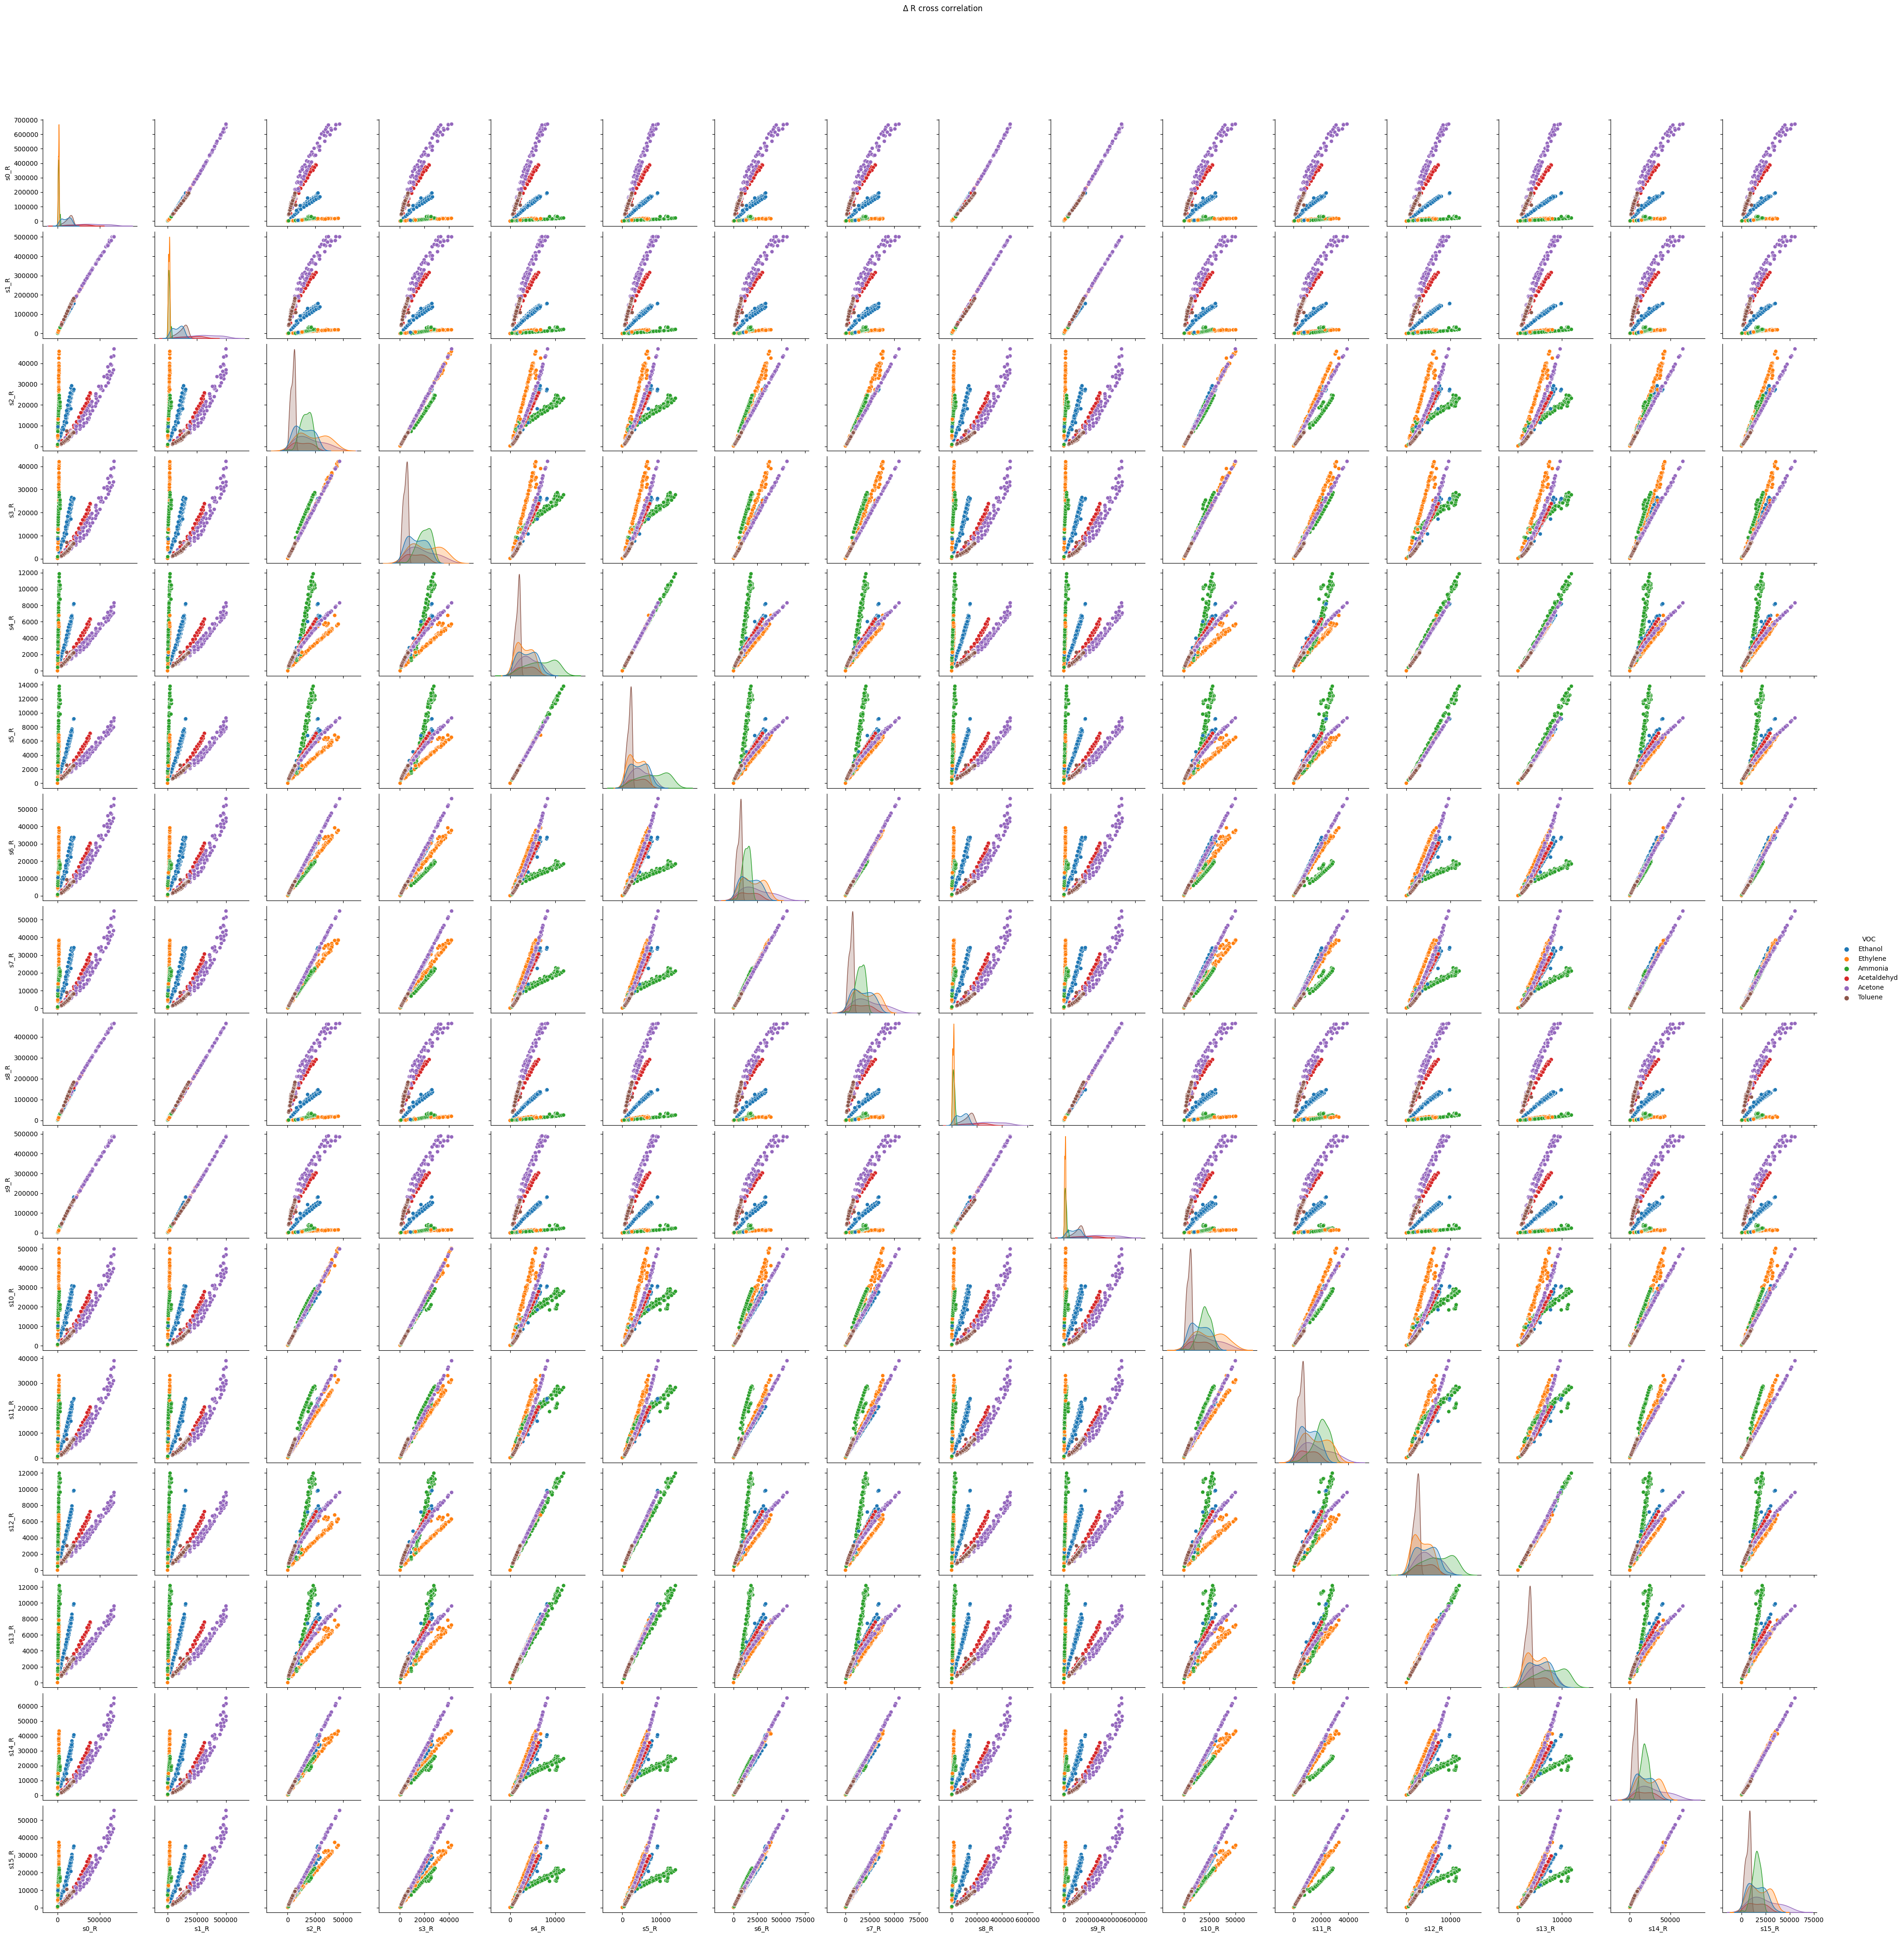

In [8]:
# Pair plot ===============
#plt.figure(figsize=(5,5))

# преоброазовать в числа все кроме колонки названий веществ
cols=[i for i in df.columns if i not in ["VOC"]]
for col in cols:
    df[col]=pd.to_numeric(df[col], errors='ignore')

# колонки данных начинаются с третьей, берем каждую восьмую.    
test = df_columns[2::8]

sns.pairplot(df, vars=test, hue='VOC').fig.suptitle('$\Delta$ R cross correlation', y=1.05)  
#g = sns.pairplot(df, vars=test, hue='VOC')  
#g.fig.suptitle("$\Delta R$ cross correlation")


plt.show()

В принципе заметная корреляция не у всех сенсоров, может можно обойтись и меньшим числом параметров (и если проверить остальные - то может аргументированно от них и отказаться, если там видно будет что информации они дают меньше).

Но сперва лучше построить корреляцию внутри параметров одного сенсора (на примере двух).

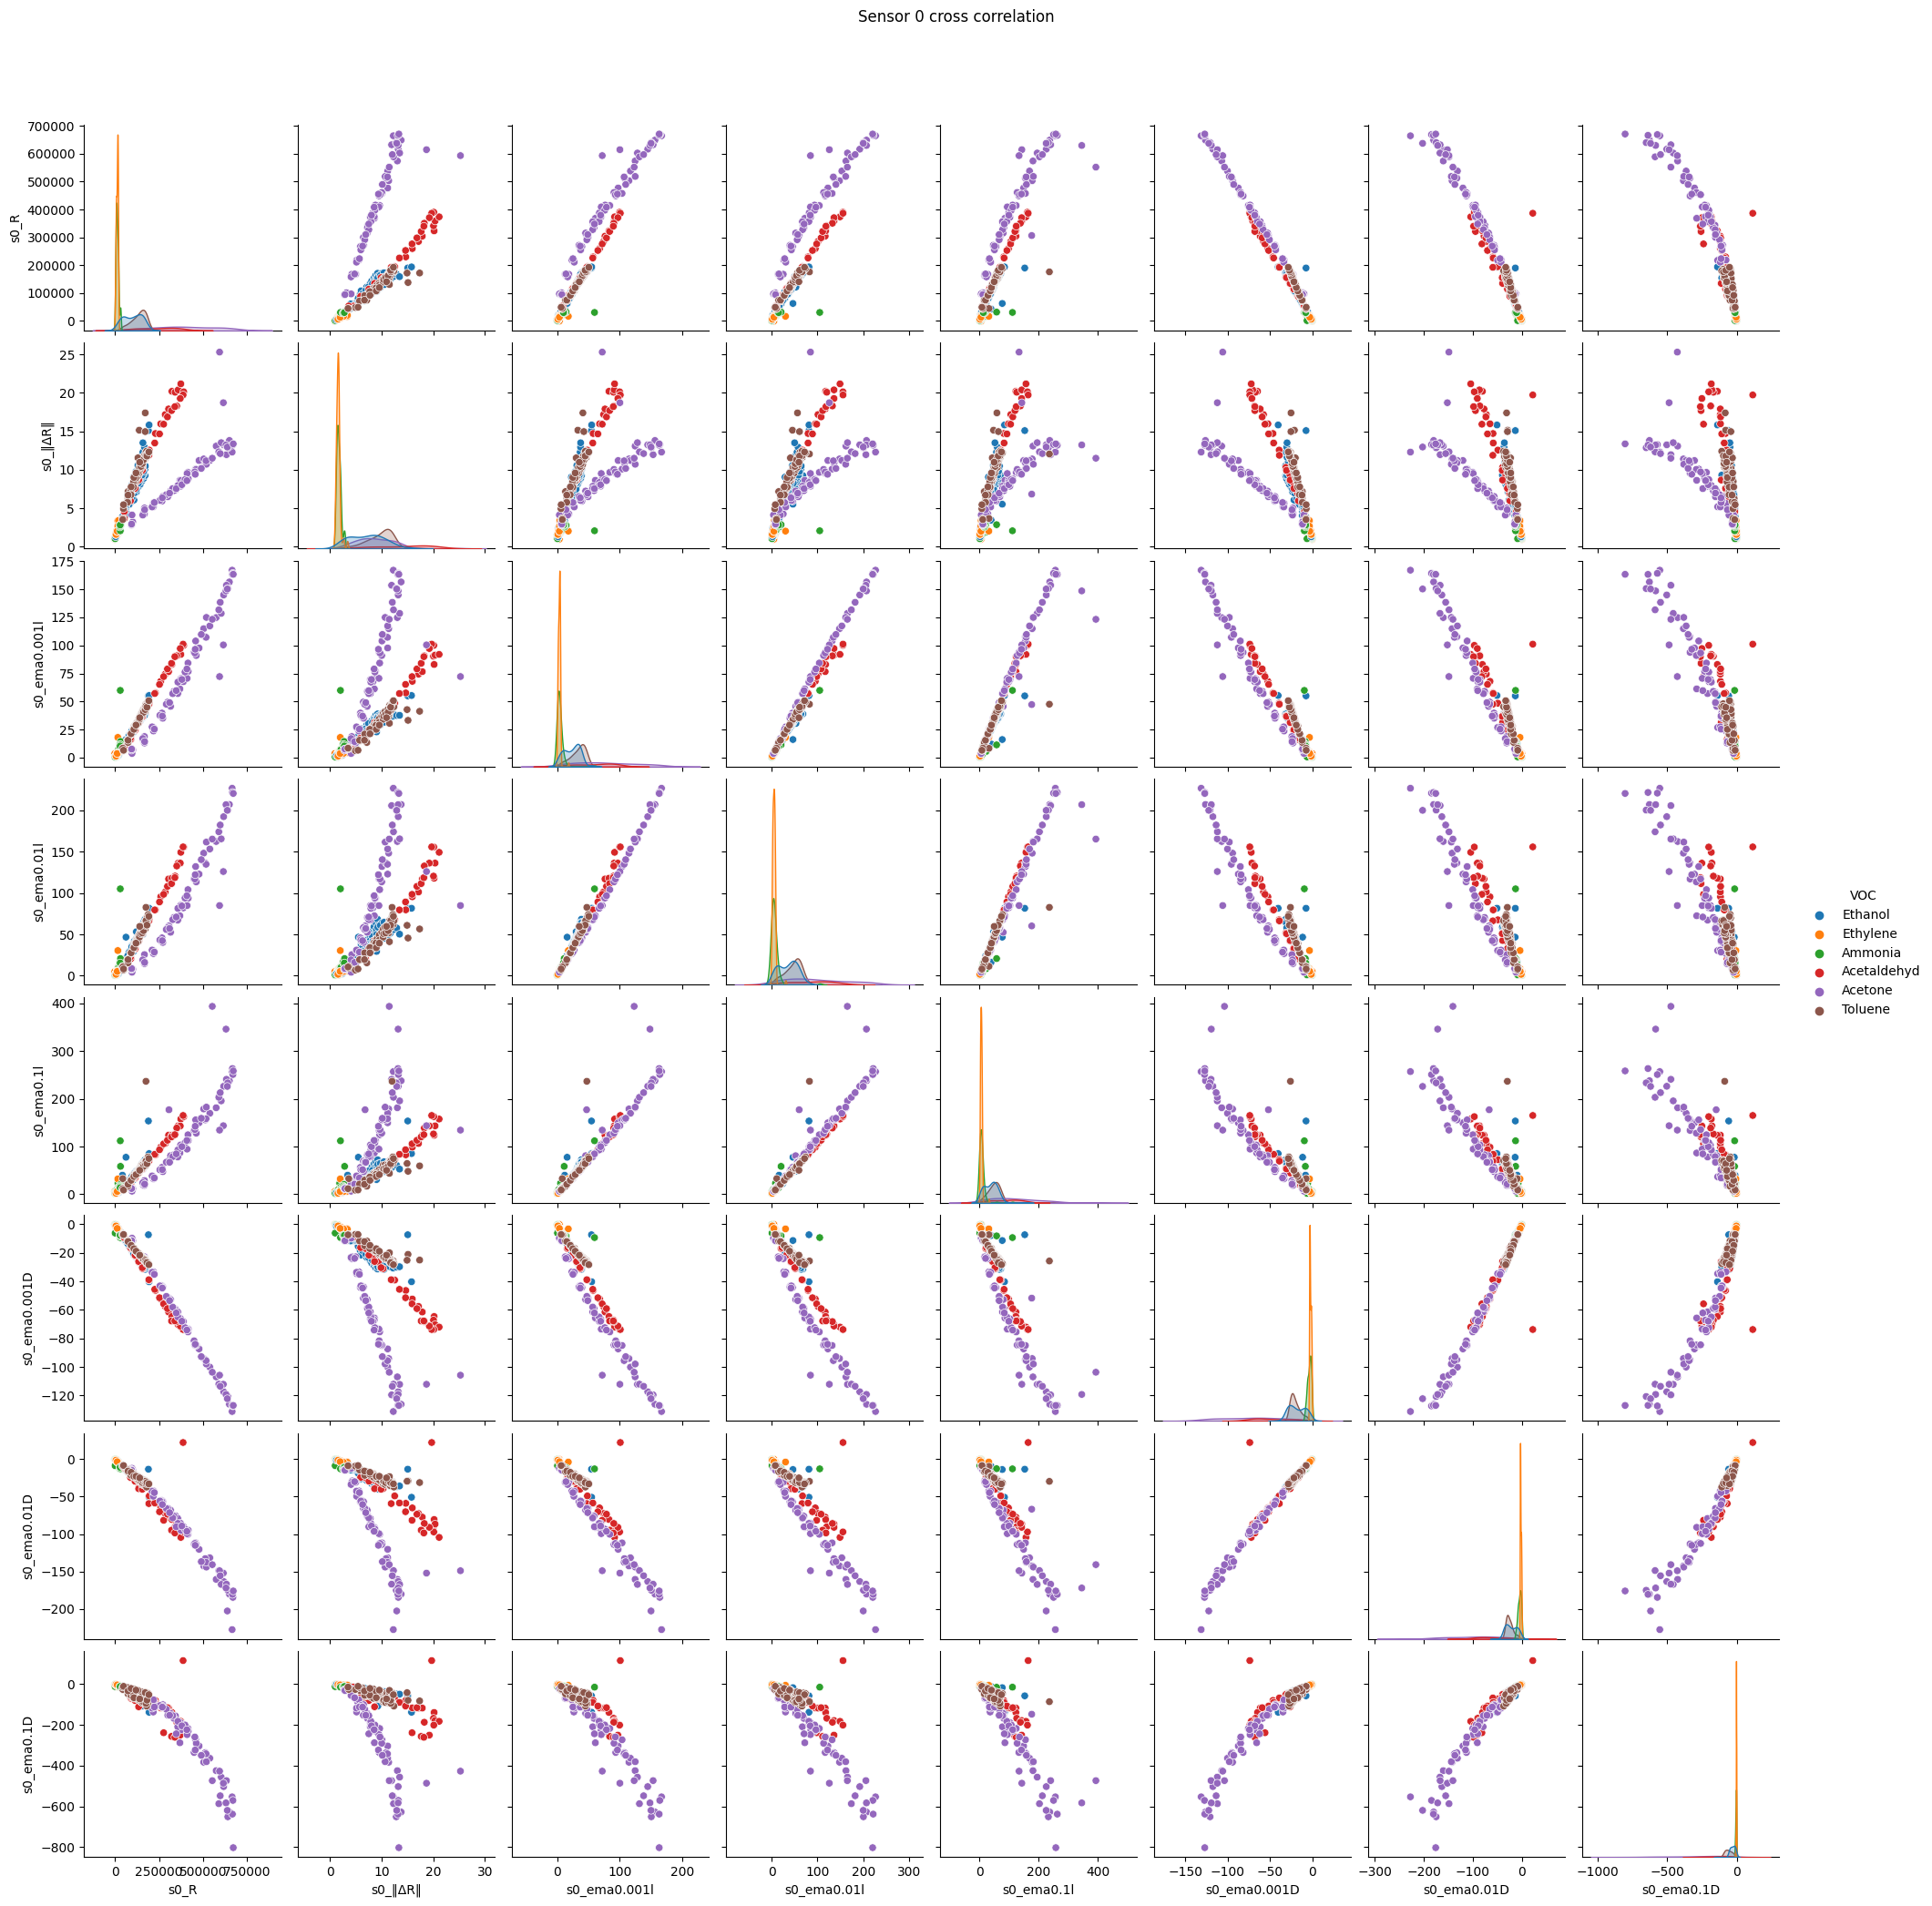

In [9]:
# Pair plot ===============
#plt.figure(figsize=(5,5))

# преоброазовать в числа все кроме колонки названий веществ
cols=[i for i in df.columns if i not in ["VOC"]]
for col in cols:
    df[col]=pd.to_numeric(df[col], errors='ignore')

# колонки данных начинаются с третьей    
sensor = 0
test = df_columns[2 + sensor: 2 + sensor + 8]

sns.pairplot(df, vars=test, hue='VOC').fig.suptitle(f'Sensor {sensor} cross correlation', y=1.05)  
#g = sns.pairplot(df, vars=test, hue='VOC')  
#g.fig.suptitle("$\Delta R$ cross correlation")


plt.show()

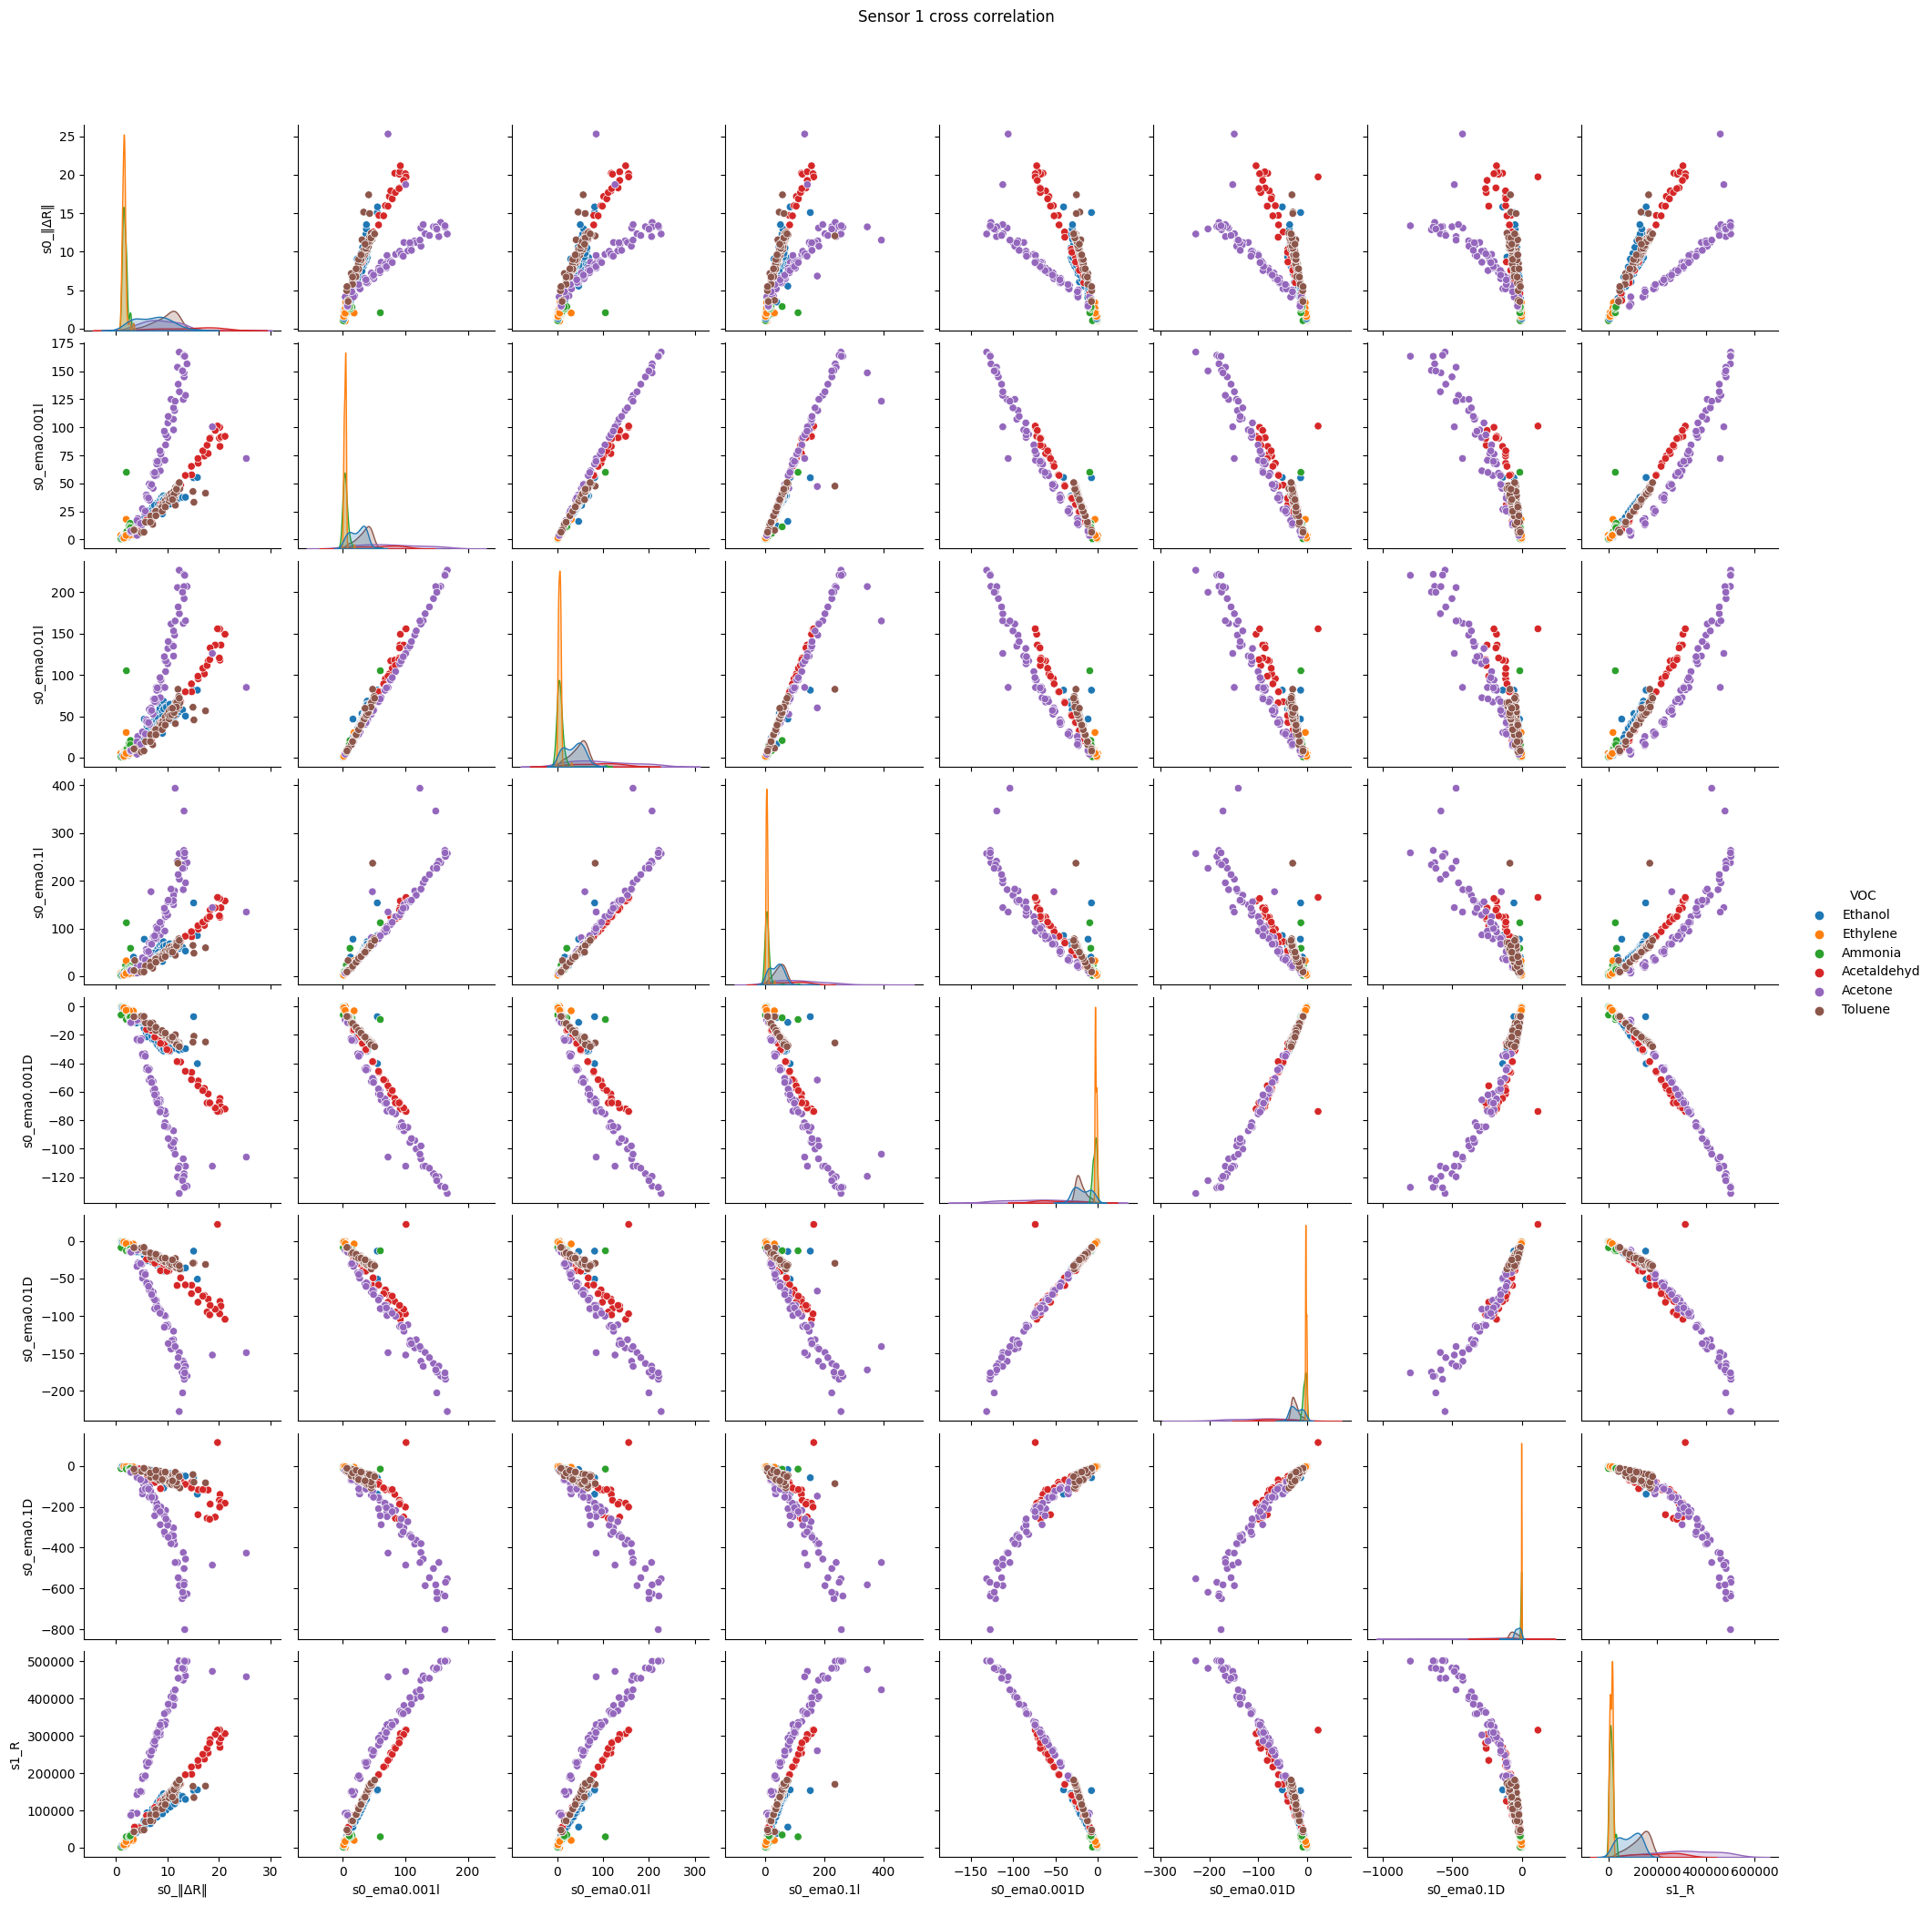

In [10]:
# Pair plot ===============
#plt.figure(figsize=(5,5))

# преоброазовать в числа все кроме колонки названий веществ
cols=[i for i in df.columns if i not in ["VOC"]]
for col in cols:
    df[col]=pd.to_numeric(df[col], errors='ignore')

# колонки данных начинаются с третьей    
sensor = 1
test = df_columns[2 + sensor: 2 + sensor + 8]

sns.pairplot(df, vars=test, hue='VOC').fig.suptitle(f'Sensor {sensor} cross correlation', y=1.05)  
#g = sns.pairplot(df, vars=test, hue='VOC')  
#g.fig.suptitle("$\Delta R$ cross correlation")


plt.show()

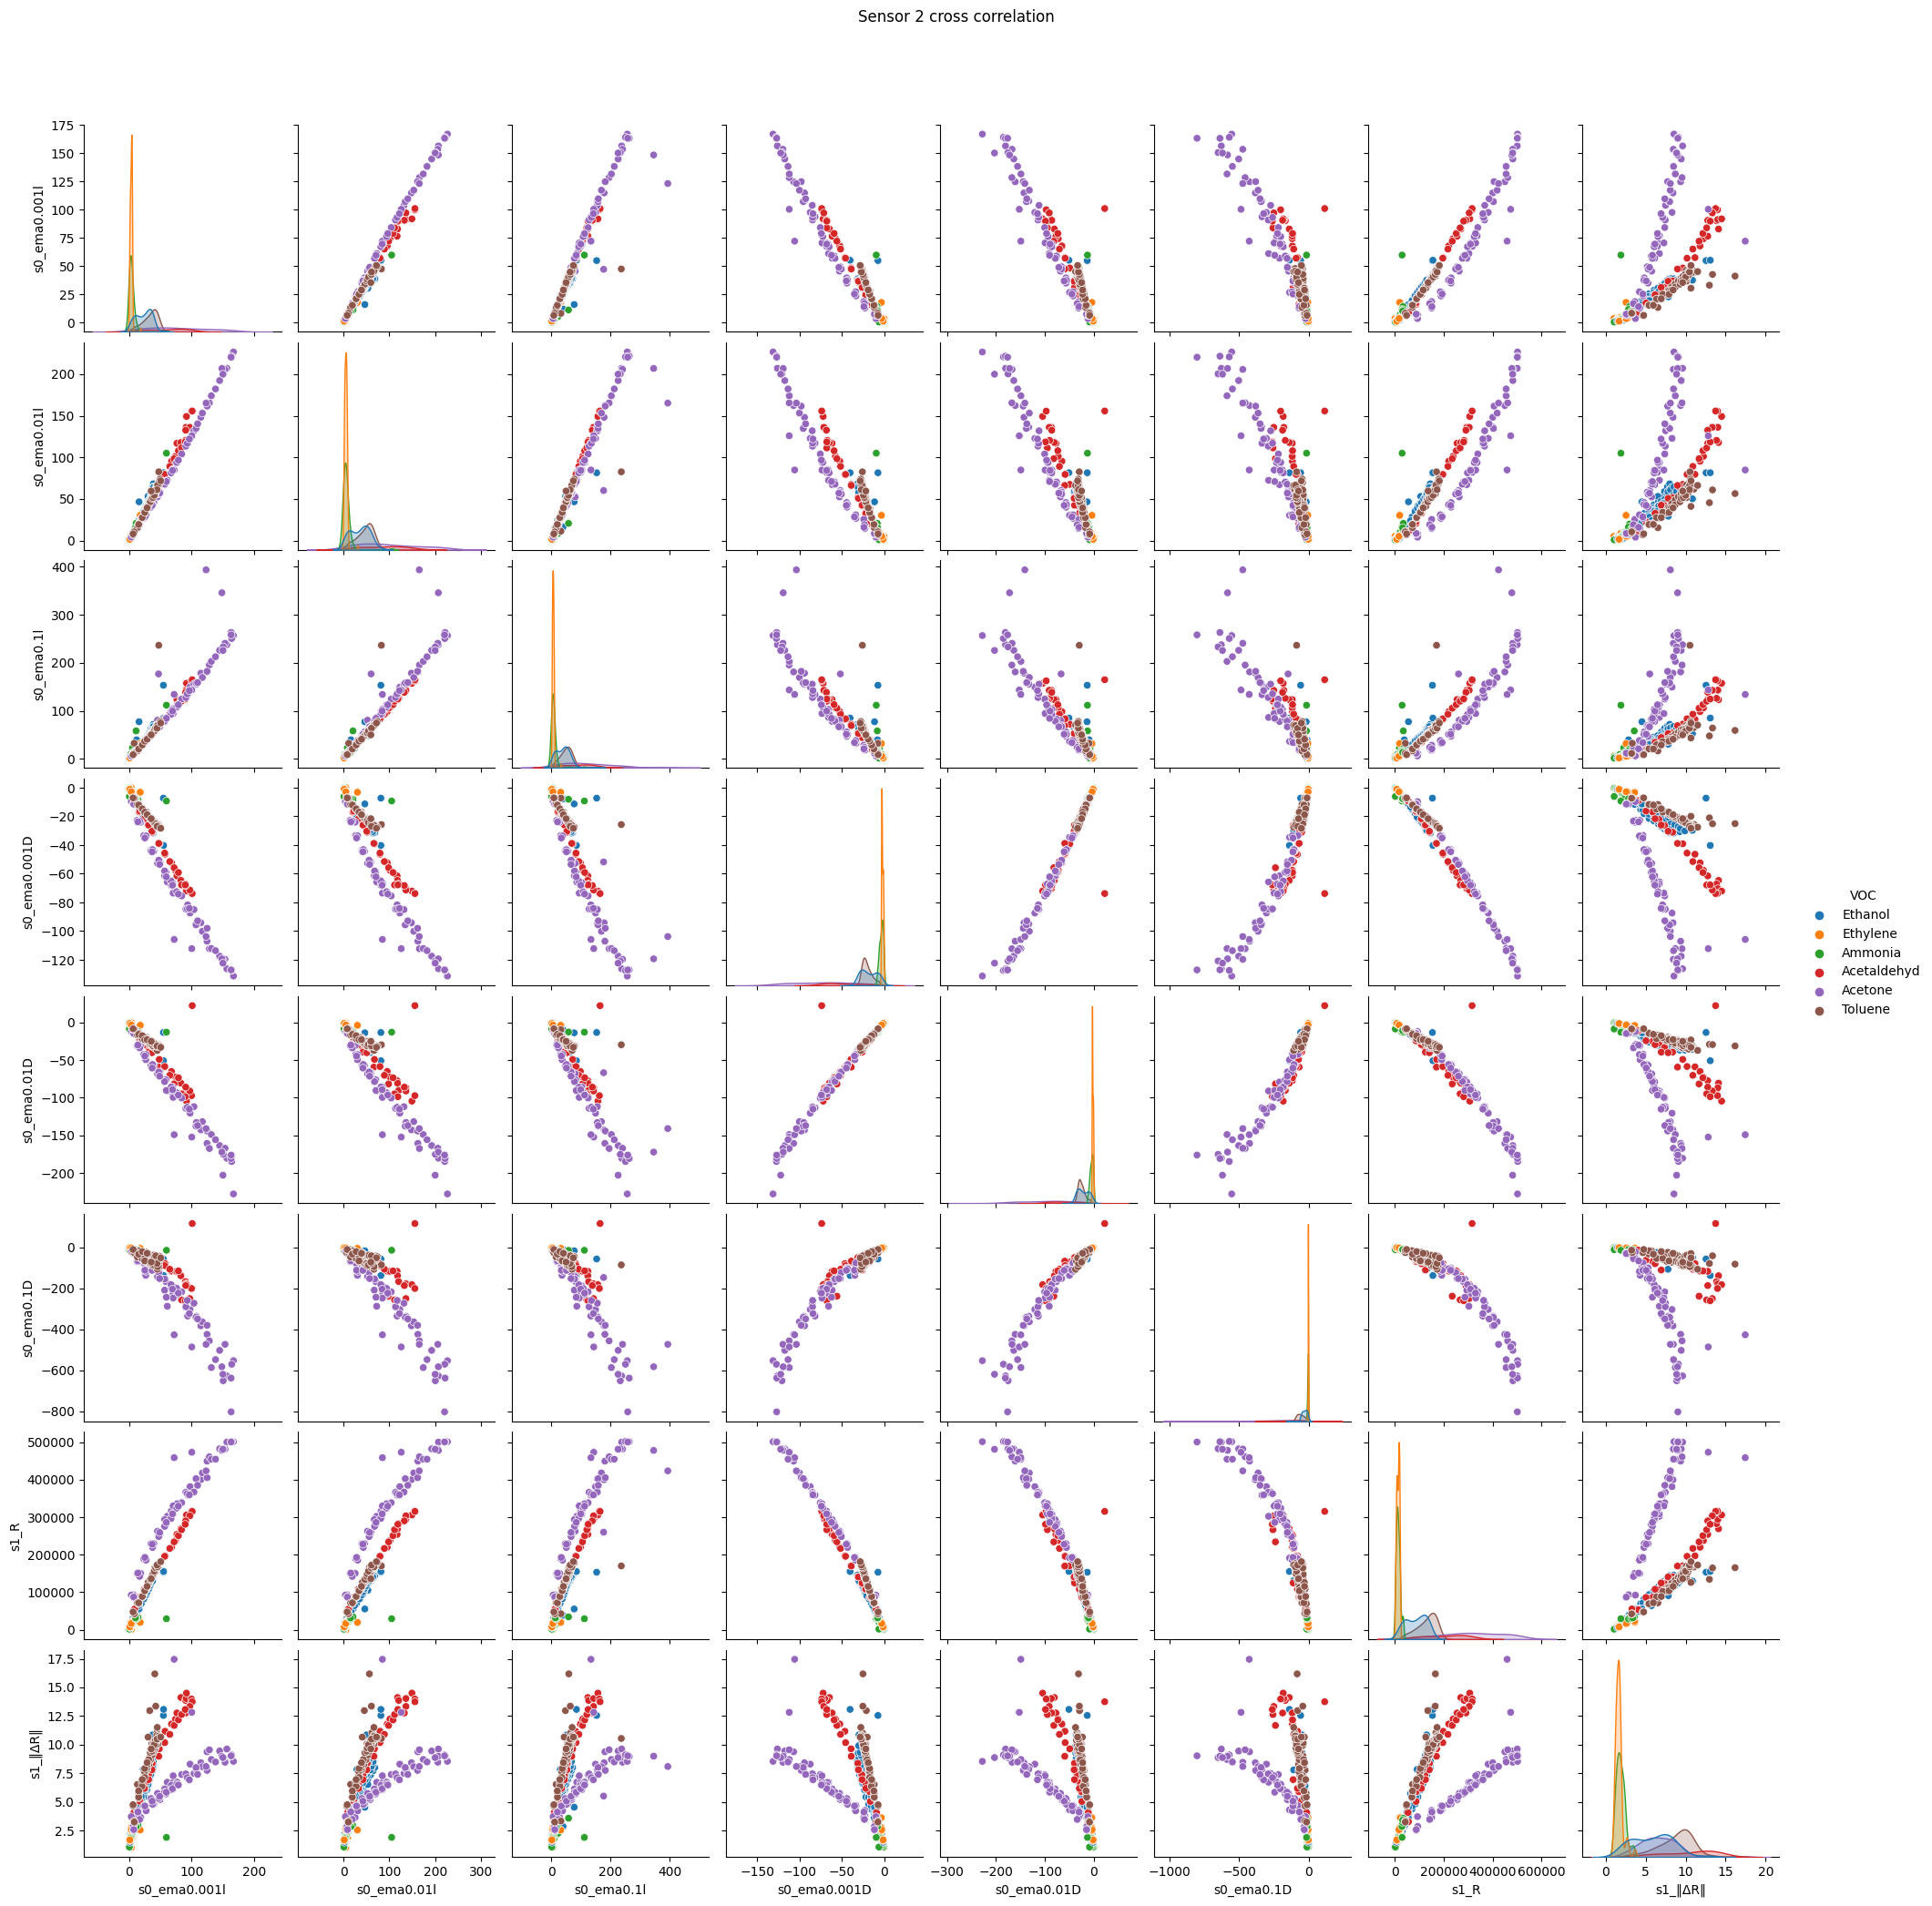

In [11]:
# Pair plot ===============
#plt.figure(figsize=(5,5))

# преоброазовать в числа все кроме колонки названий веществ
cols=[i for i in df.columns if i not in ["VOC"]]
for col in cols:
    df[col]=pd.to_numeric(df[col], errors='ignore')

# колонки данных начинаются с третьей    
sensor = 2
test = df_columns[2 + sensor: 2 + sensor + 8]

sns.pairplot(df, vars=test, hue='VOC').fig.suptitle(f'Sensor {sensor} cross correlation', y=1.05)  
#g = sns.pairplot(df, vars=test, hue='VOC')  
#g.fig.suptitle("$\Delta R$ cross correlation")


plt.show()

Конечно данные сильно коррелируют и пересекаются (только ацетон выделяется), но куда без этого .. видимо все оставляем.


Теперь можно PCA сделать.

## PCA

Смотрим как отличается PCA если строить по всем данным или только по основным ('𝑅', '‖Δ𝑅‖')

In [12]:
from sklearn.decomposition import PCA as sk_pca
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap

from scipy.signal import savgol_filter
import seaborn as sns

In [13]:

feat1 = df.values[:,2:]

# select columns with main features
p = list(range(len(df_columns)))
main_comp = [v for i, v in enumerate(p) if (i - 2) % 8 in {0, 1}]
feat2 = df.values[:,main_comp]

#feat = df.values[:,2::8]


# Initialise
skpca1 = sk_pca(n_components=10)
skpca2 = sk_pca(n_components=10)

nfeat1 = StandardScaler().fit_transform(feat1)
nfeat2 = StandardScaler().fit_transform(feat2)

# Fit the spectral data and extract the explained variance ratio
X1 = skpca1.fit(nfeat1)
expl_var_1 = X1.explained_variance_ratio_

X2 = skpca2.fit(nfeat2)
expl_var_2 = X2.explained_variance_ratio_

Строим графики парами - все переменные и только основные 2.

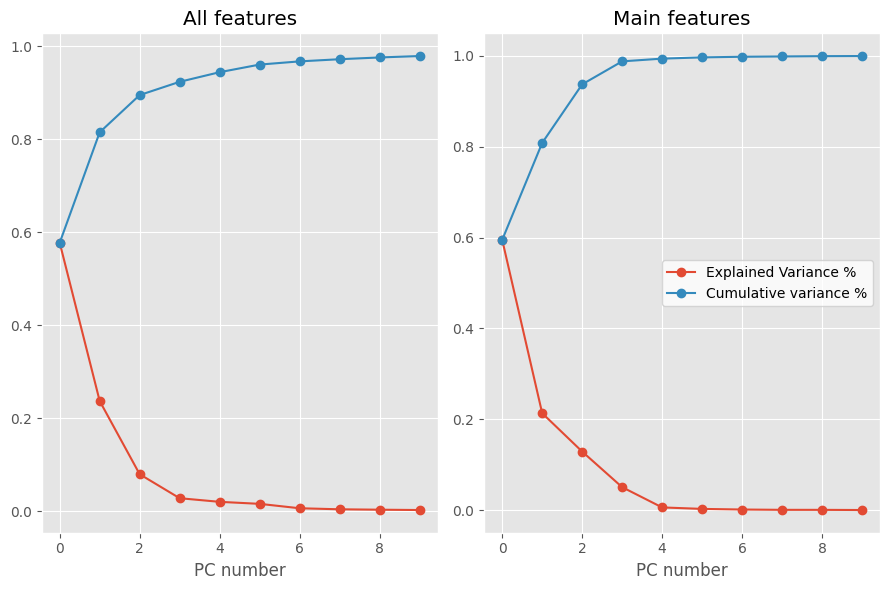

In [14]:
# Plot data
with plt.style.context(('ggplot')):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,6))
    fig.set_tight_layout(True)
 
    ax1.plot(expl_var_1,'-o', label="Explained Variance %")
    ax1.plot(np.cumsum(expl_var_1),'-o', label = 'Cumulative variance %')
    ax1.set_xlabel("PC number")
    ax1.set_title('All features')
 
    ax2.plot(expl_var_2,'-o', label="Explained Variance %")
    ax2.plot(np.cumsum(expl_var_2),'-o', label = 'Cumulative variance %')
    ax2.set_xlabel("PC number")
    ax2.set_title('Main features')
 
plt.legend()
plt.show()

Где-то три компонента желательно иметь.

Нарисуем РСА, можно еще концентрацию добавить как яркость точки (параметр alpha=1.0 в функцию scatter).

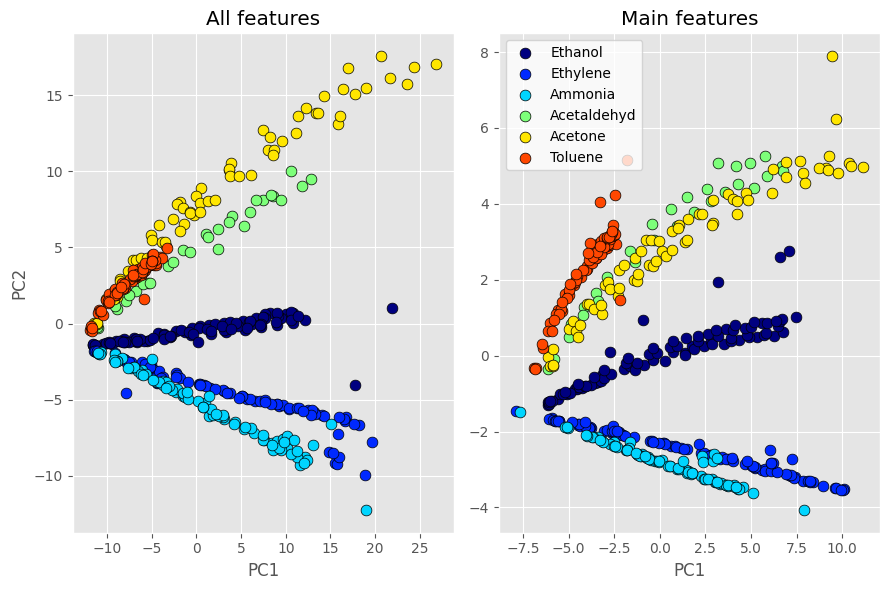

In [15]:
skpca1 = sk_pca(n_components=2)
skpca2 = sk_pca(n_components=2)
 
# Transform on the scaled features
Xt1 = skpca1.fit_transform(nfeat1) 
Xt2 = skpca2.fit_transform(nfeat2) 

# Define the labels for the plot legend
labplot = list(voc.values()) 
 
# Scatter plot
colors = [plt.cm.jet(float(i)/len(labplot)) for i in range(len(labplot))]

with plt.style.context(('ggplot')):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,6))
    fig.set_tight_layout(True)
 
    for i, u in enumerate(labplot):
        col = np.expand_dims(np.array(colors[i]), axis=0)
        xi = [Xt1[j,0] for j in range(len(Xt1[:,0])) if df['VOC'].iloc[j] == u]
        yi = [Xt1[j,1] for j in range(len(Xt1[:,1])) if df['VOC'].iloc[j] == u]
        ax1.scatter(xi, yi, c=col, s=60, edgecolors='k',label=str(u))

    
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    ax1.set_title('All features')
 
    for i, u in enumerate(labplot):
        col = np.expand_dims(np.array(colors[i]), axis=0)
        xi = [Xt2[j,0] for j in range(len(Xt2[:,0])) if df['VOC'].iloc[j] == u]
        yi = [Xt2[j,1] for j in range(len(Xt2[:,1])) if df['VOC'].iloc[j] == u]
        ax2.scatter(xi, yi, c=col, s=60, edgecolors='k',label=str(u))
    
    ax2.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    ax2.set_title('Main features')
 
plt.legend()
plt.show()

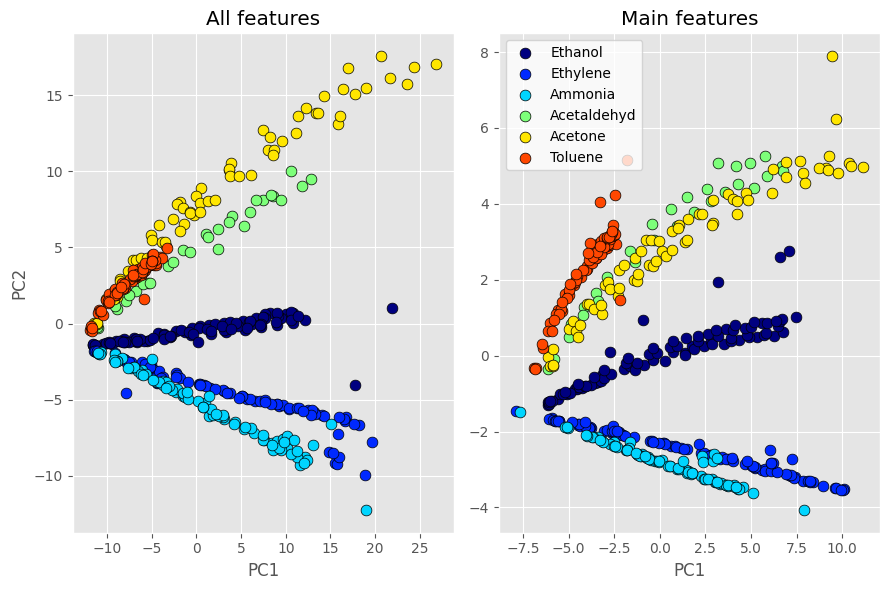

In [16]:
skpca1 = sk_pca(n_components=3)
skpca2 = sk_pca(n_components=3)
 
# Transform on the scaled features
Xt1 = skpca1.fit_transform(nfeat1) 
Xt2 = skpca2.fit_transform(nfeat2) 

# Define the labels for the plot legend
labplot = list(voc.values()) 
 
# Scatter plot
colors = [plt.cm.jet(float(i)/len(labplot)) for i in range(len(labplot))]

with plt.style.context(('ggplot')):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,6))
    fig.set_tight_layout(True)
 
    for i, u in enumerate(labplot):
        col = np.expand_dims(np.array(colors[i]), axis=0)
        xi = [Xt1[j,0] for j in range(len(Xt1[:,0])) if df['VOC'].iloc[j] == u]
        yi = [Xt1[j,1] for j in range(len(Xt1[:,1])) if df['VOC'].iloc[j] == u]
        ax1.scatter(xi, yi, c=col, s=60, edgecolors='k',label=str(u))

    
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    ax1.set_title('All features')
 
    for i, u in enumerate(labplot):
        col = np.expand_dims(np.array(colors[i]), axis=0)
        xi = [Xt2[j,0] for j in range(len(Xt2[:,0])) if df['VOC'].iloc[j] == u]
        yi = [Xt2[j,1] for j in range(len(Xt2[:,1])) if df['VOC'].iloc[j] == u]
        ax2.scatter(xi, yi, c=col, s=60, edgecolors='k',label=str(u))
    
    ax2.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    ax2.set_title('Main features')
 
plt.legend()
plt.show()

Теперь можно все три отобразить в 3D, может лучше будет видно потери от выбрасывания второстепенных данных.





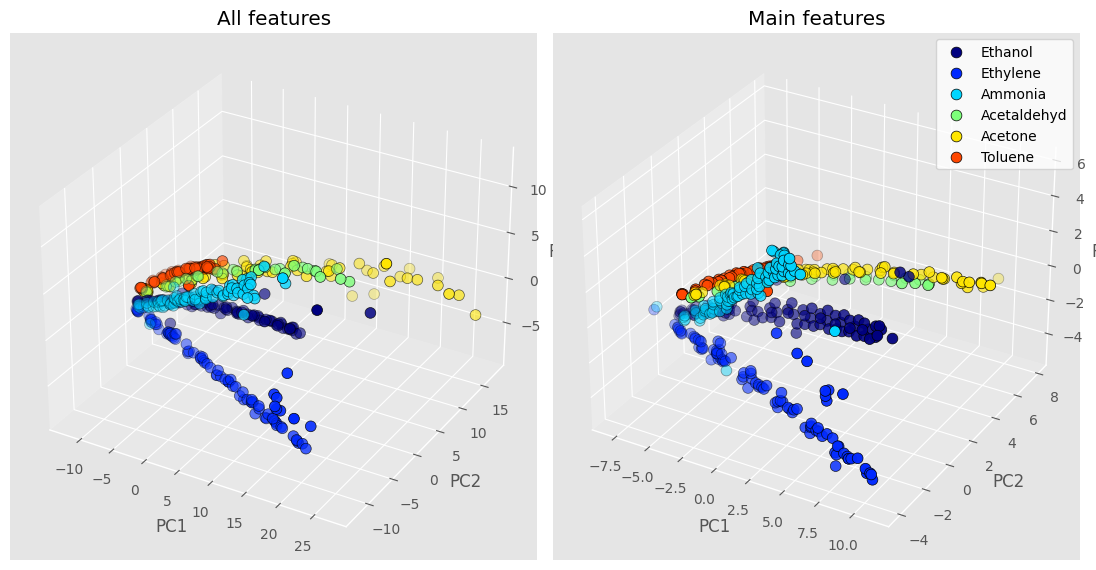

In [17]:
skpca1 = sk_pca(n_components=3)
skpca2 = sk_pca(n_components=3)
 
# Transform on the scaled features
Xt1 = skpca1.fit_transform(nfeat1) 
Xt2 = skpca2.fit_transform(nfeat2) 

# Define the labels for the plot legend
labplot = list(voc.values()) 
 
# Scatter plot
colors = [plt.cm.jet(float(i)/len(labplot)) for i in range(len(labplot))]

with plt.style.context(('ggplot')):
    fig = plt.figure(figsize=(11,6))
    fig.set_tight_layout(True)

    ax1 = fig.add_subplot(121, projection = '3d')
 
    for i, u in enumerate(labplot):
        col = np.expand_dims(np.array(colors[i]), axis=0)
        xi = [Xt1[j,0] for j in range(len(Xt1[:,0])) if df['VOC'].iloc[j] == u]
        yi = [Xt1[j,1] for j in range(len(Xt1[:,1])) if df['VOC'].iloc[j] == u]
        zi = [Xt1[j,2] for j in range(len(Xt1[:,2])) if df['VOC'].iloc[j] == u]
        ax1.scatter(xi, yi, zi, c=col, s=60, edgecolors='k',label=str(u))

    
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    ax1.set_zlabel("PC3")
    ax1.set_title('All features')
 
    ax2 = fig.add_subplot(122, projection = '3d')

    for i, u in enumerate(labplot):
        col = np.expand_dims(np.array(colors[i]), axis=0)
        xi = [Xt2[j,0] for j in range(len(Xt2[:,0])) if df['VOC'].iloc[j] == u]
        yi = [Xt2[j,1] for j in range(len(Xt2[:,1])) if df['VOC'].iloc[j] == u]
        zi = [Xt2[j,2] for j in range(len(Xt2[:,2])) if df['VOC'].iloc[j] == u]
        ax2.scatter(xi, yi, zi, c=col, s=60, edgecolors='k',label=str(u))
    
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")
    ax2.set_zlabel("PC3")
    ax2.set_title('Main features')
 
plt.legend()
plt.show()

Тут видно что в трех компонентах данные проще разделять.
С ними и проведем кластеризацию и оценку точности.